## 导入所需库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict
from sklearn.neighbors import KNeighborsClassifier

In [2]:
crime=pd.read_csv('crime.csv',encoding = "ISO-8859-1")

In [3]:
crime.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [4]:
np.min(crime['OCCURRED_ON_DATE'])

'2015-06-15 00:00:00'

In [8]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319073 entries, 0 to 319072
Data columns (total 17 columns):
INCIDENT_NUMBER        319073 non-null object
OFFENSE_CODE           319073 non-null int64
OFFENSE_CODE_GROUP     319073 non-null object
OFFENSE_DESCRIPTION    319073 non-null object
DISTRICT               317308 non-null object
REPORTING_AREA         319073 non-null object
SHOOTING               1019 non-null object
OCCURRED_ON_DATE       319073 non-null object
YEAR                   319073 non-null int64
MONTH                  319073 non-null int64
DAY_OF_WEEK            319073 non-null object
HOUR                   319073 non-null int64
UCR_PART               318983 non-null object
STREET                 308202 non-null object
Lat                    318124 non-null float64
Long                   318124 non-null float64
Location               319073 non-null object
dtypes: float64(2), int64(4), object(11)
memory usage: 41.4+ MB


缺失值出现于‘DISTRICT’，‘SHOOTING’，‘UCR_PART’，‘STREET’及坐标中，其中‘SHOOTING’缺失较为严重。

In [9]:
crime.describe()

,OFFENSE_CODE,YEAR,MONTH,HOUR,Lat,Long
count,319073.000000,319073.000000,319073.000000,319073.000000,318124.000000,318124.000000
mean,2317.546956,2016.560586,6.609719,13.118205,39.686486,-66.662121
std,1185.285543,0.996344,3.273691,6.294205,10.232733,17.161958
min,111.000000,2015.000000,1.000000,0.000000,-1.000000,-71.178674
25%,1001.000000,2016.000000,4.000000,9.000000,42.291045,-71.095324
50%,2907.000000,2017.000000,7.000000,14.000000,42.321305,-71.075723
75%,3201.000000,2017.000000,9.000000,18.000000,42.347310,-71.060120
max,3831.000000,2018.000000,12.000000,23.000000,42.395042,0.000000


注意到经纬度中都出现了-1，明显这个地点并不在波士顿，可以考虑这是个错误数据。

首先对于经纬度，由于‘Lat’与‘Long’的数据都来自于‘Location’，因此可以由‘Location’来填补。

In [10]:
for index in crime[pd.isnull(crime['Lat'])].index:
    if pd.isnull(crime.loc[index,'Lat']):
        crime.loc[index,'Lat']=float(crime.loc[index,'Location'].split(',')[0].replace('(',''))
    if pd.isnull(crime.loc[index,'Long']):
        crime.loc[index,'Long']=float(crime.loc[index,'Location'].split(',')[1].replace(')',''))

接下来处理错误的经纬度。

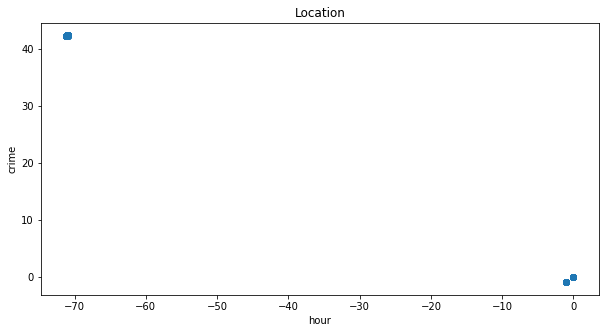

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(crime['Long'],crime['Lat'])
plt.title('Location')
plt.xlabel('hour')
plt.ylabel('crime')
plt.show()

右下角的点即为极端坐标，在此我们剔除掉极端的坐标。在此我们可以将坐标范围定义在$[42,43]$，$[-72,-71]$内。

In [12]:
crime=crime[crime['Lat']>42]
crime=crime[crime['Lat']<43]
crime=crime[crime['Long']>-72]
crime=crime[crime['Long']<-71]

对于街区缺失值，可以使用K-近邻法依据坐标进行街区预测。

In [13]:
X=crime[pd.notnull(crime['DISTRICT'])][['Lat','Long']]
y=crime[pd.notnull(crime['DISTRICT'])]['DISTRICT']
neigh_D = KNeighborsClassifier(n_neighbors=5)
neigh_D.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [14]:
for index in crime[pd.isnull(crime['DISTRICT'])].index:
    crime.loc[index,'DISTRICT']=neigh_D.predict([crime.loc[index,['Lat','Long']]])

街道缺失值我们也采取跟填补街区缺失值一样的方法。

In [15]:
X=crime[pd.notnull(crime['STREET'])][['Lat','Long']]
y=crime[pd.notnull(crime['STREET'])]['STREET']
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [16]:
for index in crime[pd.isnull(crime['STREET'])].index:
    crime.loc[index,'STREET']=neigh.predict([crime.loc[index,['Lat','Long']]])

在‘SHOOTING’中存在缺失值并被标记为‘NaN’，利用set()检查该列里的值构成，发现缺失值实际表示“没有伴随枪击案发生”，为方便后期处理，在此将缺失值填补为0，将‘Y’修改为1。

In [17]:
set(crime['SHOOTING'])

{'Y', nan}

In [18]:
crime['SHOOTING']=crime['SHOOTING'].fillna(0)
crime['SHOOTING']=crime['SHOOTING'].replace('Y',1)

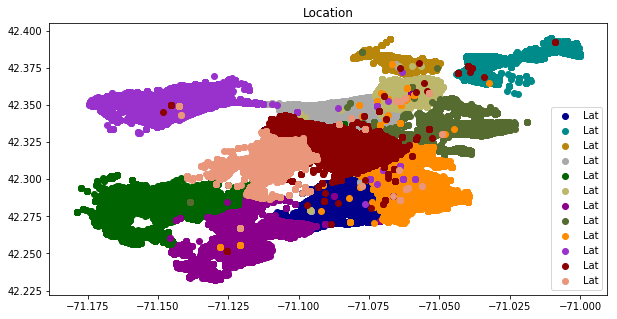

In [19]:
area=set(crime['DISTRICT'])
color=['#00008B','#008B8B','#B8860B','#A9A9A9','#006400','#BDB76B','#8B008B','#556B2F','#FF8C00','#9932CC','#8B0000','#E9967A']
plt.figure(figsize=(10,5))
for area,col in zip(area,color):
    plt.scatter(crime[crime['DISTRICT']==area]['Long'],crime[crime['DISTRICT']==area]['Lat'],color=col)
plt.legend(loc='best')    
plt.title('Location')
plt.show()

可在图中发现该数据集存在一个问题：有些点被标记成了错误的街区，有可能是记录错误所导致。同时考虑‘STREET’列可能会有同样的问题。

可注意到数据集中的时间戳包括了时分秒，我们可以将时间戳中的年月日单独提取，作为新的一列‘DATE’

In [20]:
crime['DATE']=[dt[0:10] for dt in crime['OCCURRED_ON_DATE']]

将不需要的列去除，准备去除‘INCIDENT_NUMBER’，‘OFFENSE_CODE’，‘UCR_PART’以及‘Location’。

In [21]:
crime=crime.drop(columns=['INCIDENT_NUMBER','OFFENSE_CODE','UCR_PART','Location'])

## 基础分析

首先对犯罪类型进行统计

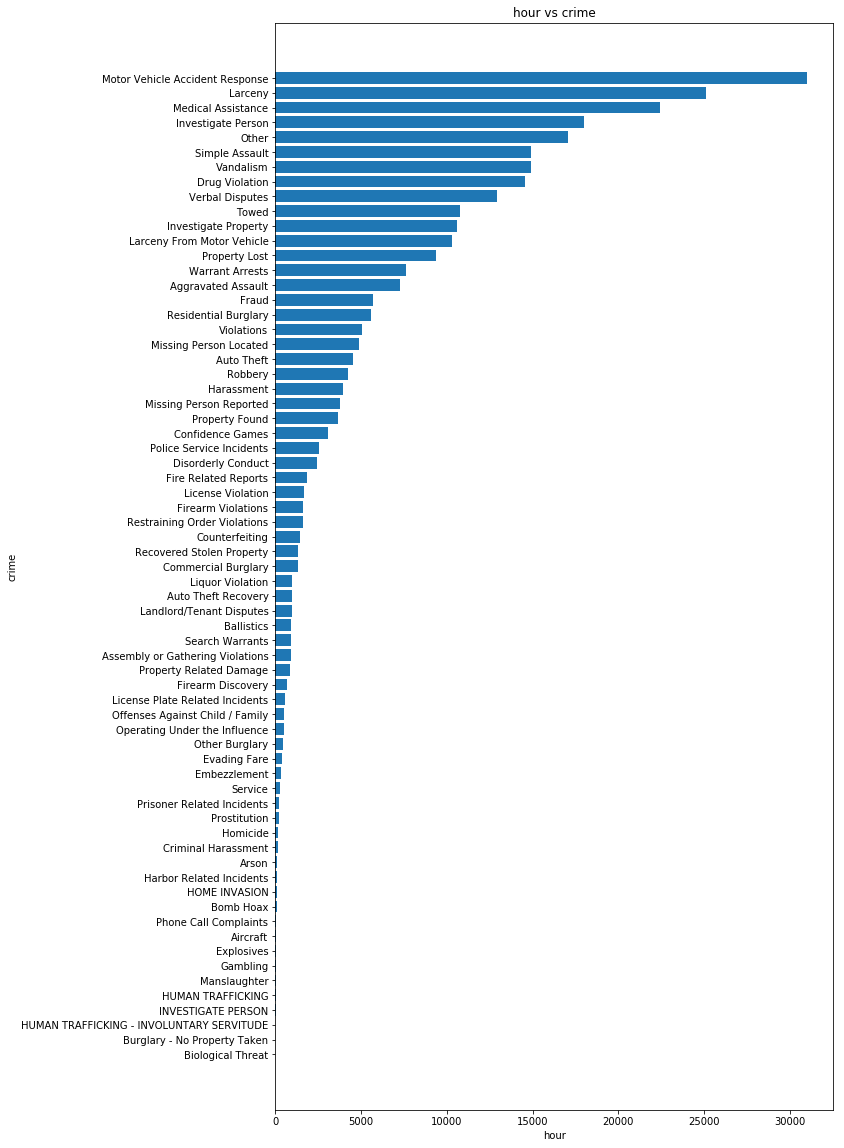

In [22]:
O=Counter(crime['OFFENSE_CODE_GROUP'].sort_values())
O=OrderedDict(sorted(O.items(), key=lambda t: t[1]))

plt.figure(figsize=(10,20))
plt.barh(list(O.keys()),list(O.values()))
plt.title('hour vs crime')
plt.xlabel('hour')
plt.ylabel('crime')
plt.show()

可见次数最多的类别是处理交通事故，盗窃，医疗援助与调查

对伴随枪击案的类别进行统计

In [23]:
crime_s=crime[crime['SHOOTING']==1]

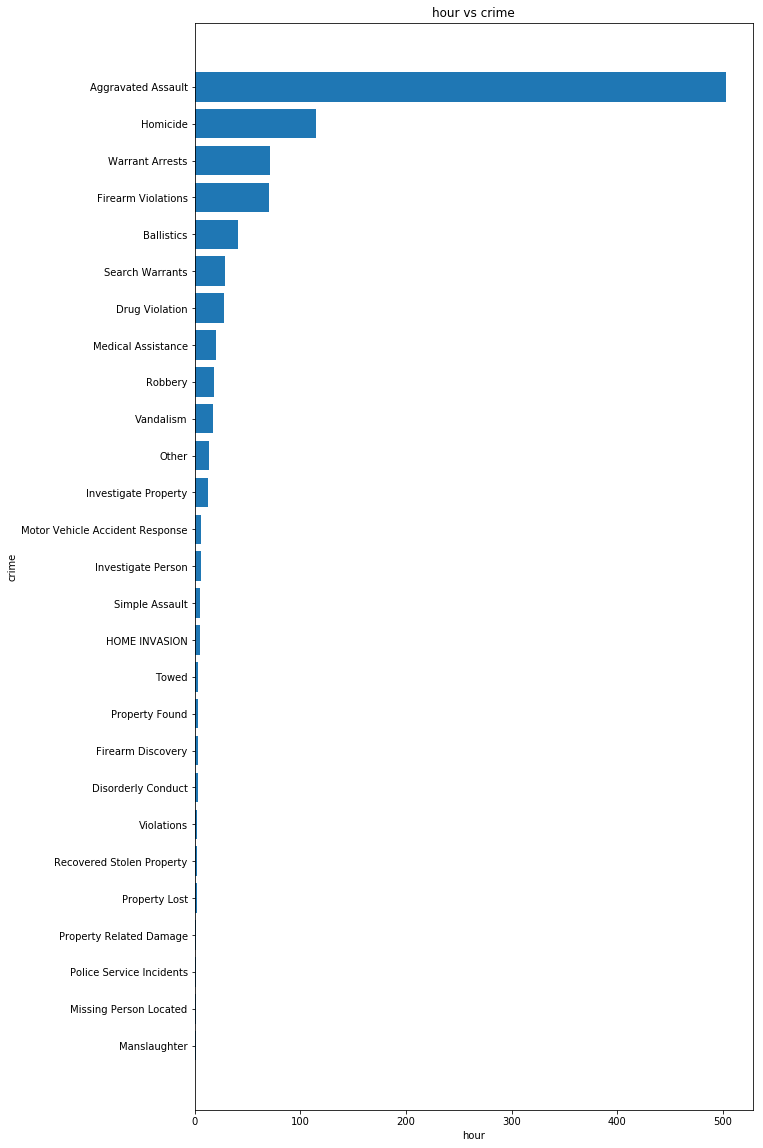

In [24]:
Og=Counter(crime_s['OFFENSE_CODE_GROUP'].sort_values())
Og=OrderedDict(sorted(Og.items(), key=lambda t: t[1]))

plt.figure(figsize=(10,20))
plt.barh(list(Og.keys()),list(Og.values()))
plt.title('hour vs crime')
plt.xlabel('hour')
plt.ylabel('crime')
plt.show()

对2017年的犯罪案件依据星期几进行分类并统计，可得周末是犯罪高发期

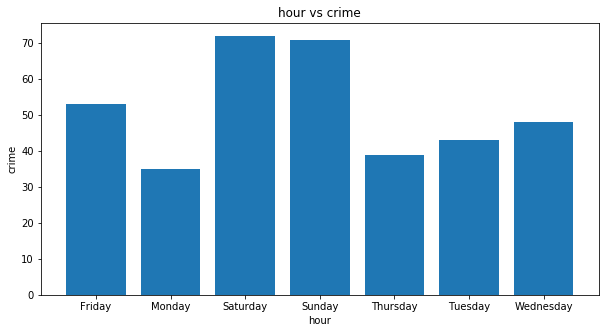

In [25]:
Day=Counter(crime_s[crime_s['YEAR']==2017]['DAY_OF_WEEK'].sort_values())

plt.figure(figsize=(10,5))
plt.bar(list(Day.keys()),list(Day.values()))
plt.title('hour vs crime')
plt.xlabel('hour')
plt.ylabel('crime')
plt.show()

In [26]:
D=Counter(crime_s[crime_s['YEAR']==2017]['DATE'].sort_values())

将2017年的案件个数绘制成折线图，并以红绿线标记周六与周日，可见大部分红绿线穿过了一些局部最大值。

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


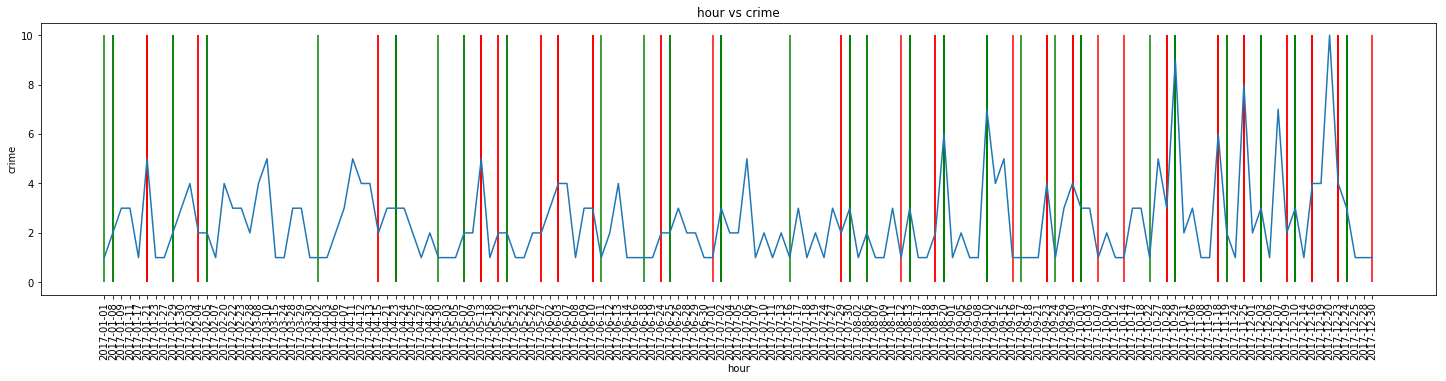

In [27]:
plt.figure(figsize=(25,5))
plt.plot(list(D.keys()),list(D.values()))
plt.xticks(list(D.keys()), rotation='vertical')
plt.vlines(list(crime_s[crime_s['DAY_OF_WEEK']=='Saturday'][crime_s['YEAR']==2017]['DATE']),0,10,colors='r')
plt.vlines(list(crime_s[crime_s['DAY_OF_WEEK']=='Sunday'][crime_s['YEAR']==2017]['DATE']),0,10,colors='g')
plt.title('hour vs crime')
plt.xlabel('hour')
plt.ylabel('crime')
plt.show()

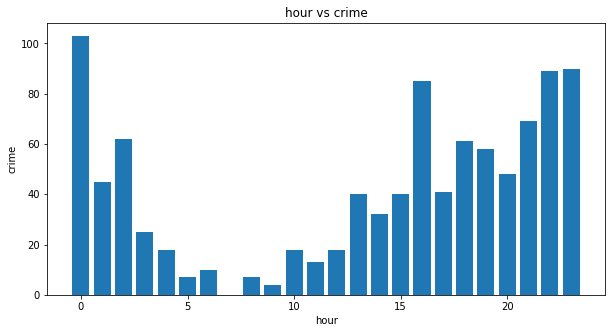

In [28]:
T=Counter(crime_s['HOUR'].sort_values())


plt.figure(figsize=(10,5))
plt.bar(list(T.keys()),list(T.values()))
plt.title('hour vs crime')
plt.xlabel('hour')
plt.ylabel('crime')
plt.show()

从图可知持枪犯罪多发生在下午16点与晚上22点至24点，早晨7点则极少发生

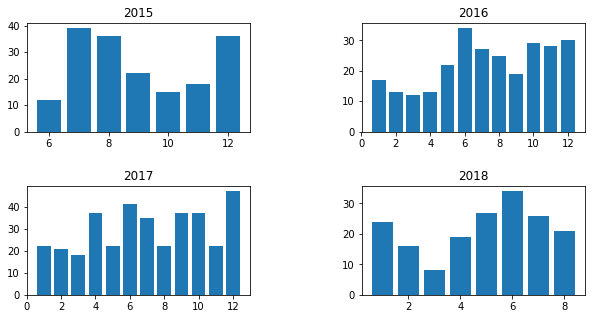

In [29]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace =0.5, hspace =0.5)
plt.subplot(221)
M=Counter(crime_s[crime_s['YEAR']==2015]['MONTH'].sort_values())
plt.bar(list(M.keys()),list(M.values()))
plt.title('2015')
plt.subplot(222)
M=Counter(crime_s[crime_s['YEAR']==2016]['MONTH'].sort_values())
plt.bar(list(M.keys()),list(M.values()))
plt.title('2016')
plt.subplot(223)
M=Counter(crime_s[crime_s['YEAR']==2017]['MONTH'].sort_values())
plt.bar(list(M.keys()),list(M.values()))
plt.title('2017')
plt.subplot(224)
M=Counter(crime_s[crime_s['YEAR']==2018]['MONTH'].sort_values())
plt.bar(list(M.keys()),list(M.values()))
plt.title('2018')
plt.show()

从图知持枪犯罪多发生在6至8月份以及12月份（由于2015年的数据从6月15日才开始记录，所以6月份的案件个数应该比数据集记录的要更多），12月份中有圣诞假期，6至8月份则为夏季，而2016-2018年每年的2到3月则都是案件个数最少的月份（是否会与天气有关），尤其是2018年3月。（经查，2018年3月份波士顿发生了支持加强枪械管制的示威游行，来源：维基百科）

## 附录：波士顿天气

In [30]:
weather=pd.read_csv('Boston weather_clean.csv')

In [31]:
weather.head()

,Year,Month,Day,High Temp (F),Avg Temp (F),Low Temp (F),High Dew Point (F),Avg Dew Point (F),Low Dew Point (F),High Humidity (%),...,Low Sea Level Press (in),High Visibility (mi),Avg Visibility (mi),Low Visibility (mi),High Wind (mph),Avg Wind (mph),High Wind Gust (mph),Snowfall (in),Precip (in),Events
0,2008,1,1,40,34,28,37,31,22,92,...,29.56,10,8,1,23,10,36,0.18,0.18,Both
1,2008,1,2,33,22,10,28,18,-3,82,...,29.55,10,10,9,28,15,38,0.00,0.00,Snow
2,2008,1,3,14,11,7,-3,-7,-9,60,...,30.22,10,10,10,25,17,32,0.00,0.00,None
3,2008,1,4,32,20,8,13,5,-8,63,...,30.37,10,10,10,23,12,28,0.00,0.00,None
4,2008,1,5,42,35,27,26,16,12,64,...,30.17,10,10,10,16,9,23,0.00,0.00,None


In [32]:
weather['DATE']=pd.to_datetime(weather[['Year','Month','Day']])

剔除2016年以前的数据。

In [33]:
weather=weather[weather['Year']>=2016]

按月份统计雨雪天气。

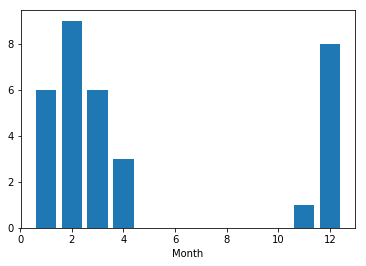

In [34]:
E=Counter(weather[weather['Events']=='Both' ]['Month'].sort_values())
plt.bar(list(E.keys()),list(E.values()))
plt.xlabel('Month')
plt.show()

可见2到3月份是雨雪天气的高发期

接下来是2016年至2018年4月波士顿降雪量，红线范围内为2-3月份。

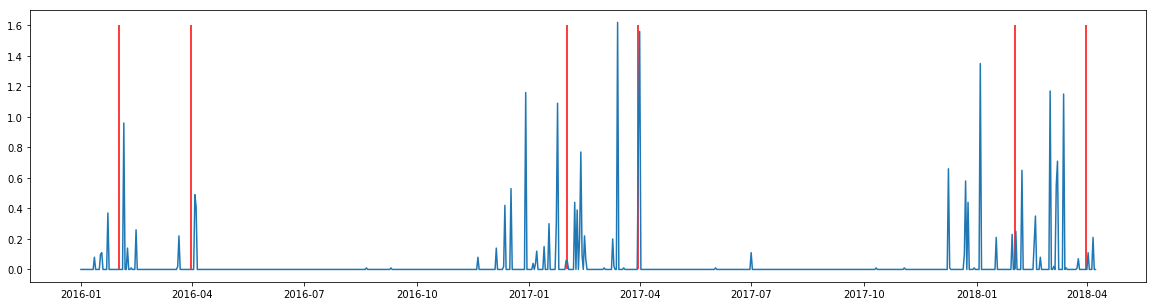

In [35]:
date=['2016-02-01','2016-03-31','2017-02-01','2017-03-31','2018-02-01','2018-03-31']
plt.figure(figsize=(20,5))
plt.plot(weather['DATE'],weather['Snowfall (in)'])
plt.xticks()
plt.vlines(date,0,1.6,colors='r')
plt.show()

2016年至2018年4月波士顿日平均气温，红线范围内为2-3月份。

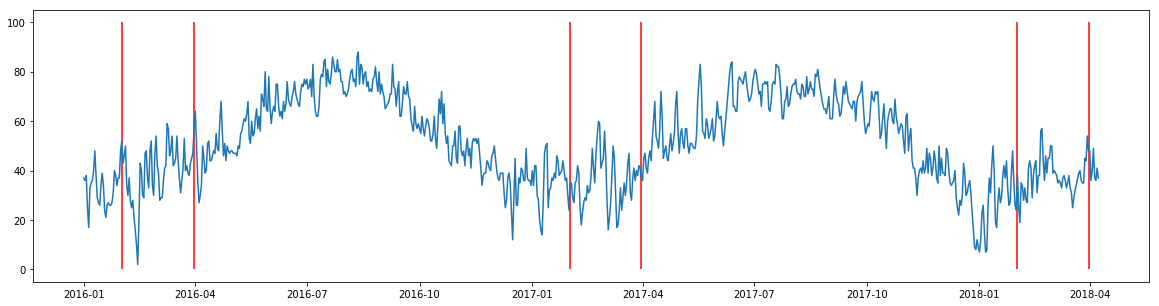

In [36]:
date=['2016-02-01','2016-03-31','2017-02-01','2017-03-31','2018-02-01','2018-03-31']
plt.figure(figsize=(20,5))
plt.plot(weather['DATE'],weather['Avg Temp (F)'])
plt.xticks()
plt.vlines(date,0,100,colors='r')
plt.show()